# Clustering Drugs from DrugBank

What chemical space is covered by DrugBank?

In [ ]:
from collections import defaultdict
import itertools as itt
import sys
import time
import os
import json
import pickle

import bio2bel
import bio2bel_drugbank
import bio2bel_hgnc
import matplotlib.pyplot as plt
import ndex2
import pandas as pd
import rdkit
from rdkit.Chem import (
    MolFromInchi, 
    Draw, 
    rdMolDescriptors,
    MACCSkeys,
)
from rdkit.Chem.Draw import IPythonConsole
from rdkit import (
    rdBase,
    DataStructs,
)
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [13]:
print(sys.version)

3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


In [14]:
print(time.asctime())

Thu Jun 28 15:05:31 2018


In [65]:
print(f'Bio2BEL Version: {bio2bel.utils.get_version()}')
print(f'Bio2BEL HGNC Version: {bio2bel_hgnc.__version__}')
print(f'Bio2BEL DrugBank Version: {bio2bel_drugbank.__version__}')
print(f'RDKit Version: {rdBase.rdkitVersion}')

Bio2BEL Version: 0.0.14-dev
Bio2BEL HGNC Version: 0.0.8-dev
Bio2BEL DrugBank Version: 0.0.2-dev
RDKit Version: 2018.09.1dev1


In [16]:
# Turn on pretty matplotlib output
%matplotlib inline

In [109]:
# Turn on pretty RDKit output
IPythonConsole.ipython_useSVG = True

In [17]:
hgnc_manager = bio2bel_hgnc.Manager()
hgnc_manager

<HgncManager url=mysql+mysqldb://root@localhost/pybel12?charset=utf8>

In [30]:
print(f'HGNC database has {hgnc_manager.count_human_genes()} human genes')

HGNC database has 42530 human genes


In [19]:
drugbank_manager = bio2bel_drugbank.Manager()
drugbank_manager

<DrugbankManager url=mysql+mysqldb://root@localhost/pybel12?charset=utf8>

In [36]:
print(f'DrugBank database has {drugbank_manager.count_drugs()} drugs '
      f'and {drugbank_manager.count_proteins()} targets')

DrugBank database has 11033 drugs and 4723 targets


In [ ]:
name_to_drugbank_id = {
    
}

In [20]:
# Calculate drug promiscuity
drug_to_hgnc_symbols = drugbank_manager.get_drug_to_hgnc_symbols()

drug_promiscuity_histogram = [
    len(hgnc_symbols) 
    for hgnc_symbols in drug_to_hgnc_symbols.values()
]

In [21]:
# Calculate gene promiscuity
hgnc_symbol_to_drugs = defaultdict(set)
for drug, genes in drug_to_hgnc_symbols.items():
    for gene in genes:
        hgnc_symbol_to_drugs[gene].add(drug)

target_promiscuity_histogram = [
    len(drugs) 
    for drugs in hgnc_symbol_to_drugs.values()
]      

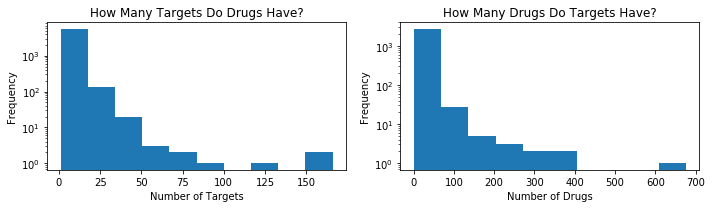

In [25]:
fix, (lax, rax) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

lax.set_title('How Many Targets Do Drugs Have?')
lax.set_xlabel('Number of Targets')
lax.set_ylabel('Frequency')
lax.hist(drug_promiscuity_histogram, log=True)

rax.set_title('How Many Drugs Do Targets Have?')
rax.set_xlabel('Number of Drugs')
rax.set_ylabel('Frequency')
rax.hist(target_promiscuity_histogram, log=True)

plt.tight_layout()
plt.show()

In [31]:
%%time

hgnc_id_symbol_mapping = hgnc_manager.build_hgnc_id_symbol_mapping()

targets = [
    hgnc_id_symbol_mapping[protein.hgnc_id[len('HGNC:'):]] 
    for protein in drugbank_manager.list_proteins() 
    if protein.hgnc_id
]
print(len(targets))

2749
CPU times: user 238 ms, sys: 13.4 ms, total: 251 ms
Wall time: 380 ms


In [123]:
%%time

drugs = [drug for drug in drugbank_manager.list_drugs() if drug.inchi]
name_to_drugbank_id = {drug.name: drug.drugbank_id for drug in drugs}
index = [drug for drug in drugs[:5] if drug.name in drug_to_hgnc_symbols]
columns = targets[10:]

r = [
    [
        target in drug_to_hgnc_symbols[drug.name]
        for target in columns
    ]
    for drug in index
]

CPU times: user 214 ms, sys: 13.3 ms, total: 227 ms
Wall time: 247 ms


In [47]:
df = pd.DataFrame(r, index=index, columns=columns)
df

,FCGR2A,FCGR2B,FCGR2C,IL2RA,IL2RB,IL2RG,TNF,TNFRSF1B,LTA,PTGS2,...,YWHAH,YWHAQ,YWHAZ,IFNA2,MSLN,ADAMTS13,SMN1,NOD2,RPE65,SSTR4
Bivalirudin,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Goserelin,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Gramicidin D,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Desmopressin,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
Cetrorelix,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# To Do

- Use appropriate distance function (jaccard) to calculate similarity between molecules based on targets
- Use RDKit to calculate descriptors for all molecules and use dimensionality reduction to plot the "chemical space"

In [142]:
mols = {
    drug.name: MolFromInchi(inchi=drug.inchi)
    for drug in tqdm(
        drugbank_manager.list_drugs(), 
        total=drugbank_manager.count_drugs()
    )
    if drug.inchi
}

RDKit ERROR: [15:15:08] ERROR: Sanitization error: Explicit valence for atom # 22 Be, 3, is greater than permitted
RDKit ERROR: [16:52:03] Explicit valence for atom # 8 Cl, 5, is greater than permitted
RDKit ERROR: [16:52:03] ERROR: Sanitization error: Explicit valence for atom # 8 Cl, 5, is greater than permitted
RDKit ERROR: [16:52:05] Explicit valence for atom # 9 Be, 4, is greater than permitted
RDKit ERROR: [16:52:05] ERROR: Sanitization error: Explicit valence for atom # 9 Be, 4, is greater than permitted
RDKit ERROR: [16:52:06] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:52:06] ERROR: Sanitization error: Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [16:52:08] Explicit valence for atom # 22 Be, 3, is greater than permitted


Show some structures from DrugBank

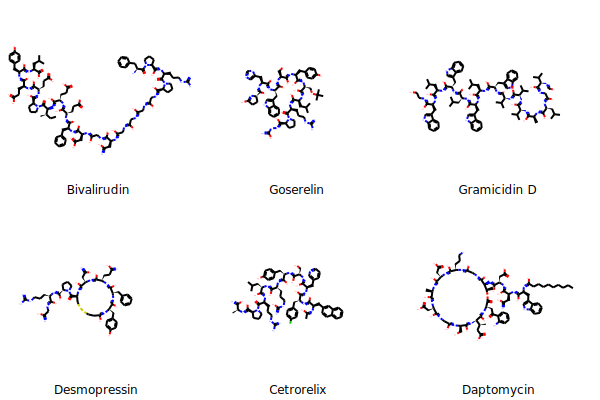

In [71]:
m, l = zip(*list(mols.items())[:6])
Draw.MolsToGridImage(l, legends=m)

Compute fingerprints for each molecule in DrugBank

In [143]:
fps = {
    name: MACCSkeys.GenMACCSKeys(mol) 
    for name, mol in tqdm(mols.items())
    if mol is not None
}

In [85]:
sim = {
    (x, y): DataStructs.FingerprintSimilarity(fps[x], fps[y]) 
    # can also use FingerprintMols
    for x, y, in tqdm(itt.combinations(fps, 2))
}

In [92]:
with open('drugbank_similarities.pkl', 'wb') as file:
    pickle.dump(sim, file=file, protocol=4)

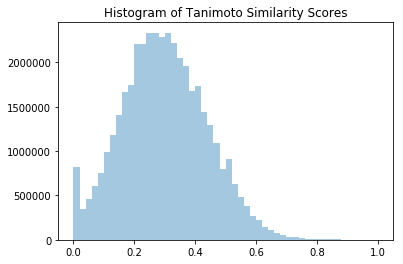

In [95]:
plt.title('Histogram of Tanimoto Similarity Scores')
sns.distplot(list(sim.values()), kde=False)
plt.show()

In [101]:
# Make BEL graph

cutoff = 0.8

sum(1 for _, similarity in sim.items() if cutoff < similarity)

33598

In [124]:
with open('drugbank-0.8-similarity.tsv', 'w') as file:
    for (x, y), similarity in tqdm(sim.items()):
        if similarity < cutoff:
            continue
        print(x, name_to_drugbank_id[x], y, name_to_drugbank_id[y], similarity, sep='\t', file=file)

Output as CX

In [115]:
cx_network = ndex2.NiceCXNetwork()

name_cx = {
    cx_network.create_node(node_name=node): node
    for node in set(itt.chain.from_iterable((sim)))
}

for (x, y), similarity in tqdm(sim.items(), desc='Adding edges'):
    if similarity < cutoff:
        continue

    edge_id = cx_network.create_edge(
        edge_source=name_cx[x],
        edge_target=name_cx[y],
    )
    
    cx_network.add_edge_attribute(
        property_of=edge_id, 
        name='similarity', 
        values=similarity,
        type='float',
    )


In [119]:
with open('drugbank-0.8-similarity.cx', 'w') as f:
    json.dump(cx_network.to_cx(), f)

Make BEL

In [132]:
import pybel
from pybel import BELGraph
from pybel.dsl import abundance
from pybel.constants import ASSOCIATION

In [139]:
graph = BELGraph(name='DrugBank chemical similarities (0.8<)', version='20180628')

graph.namespace_pattern['DRUGBANK'] = '^DB\d{5}$'
graph.annotation_pattern['Similarity'] = '^[+-]?([0-9]*[.])?[0-9]+$'

for (x, y), similarity in tqdm(sim.items(), desc='Adding edges'):
    if similarity < cutoff:
        continue
        
    graph.add_qualified_edge(
        abundance('DRUGBANK', name=name_to_drugbank_id[x]),
        abundance('DRUGBANK', name=name_to_drugbank_id[x]),
        relation=ASSOCIATION,
        evidence='Calculated from DrugBank with MACCS keys and tanimoto similarity',
        citation='29126136',
        annotations={'Similarity': str(similarity)},
    )

In [140]:
pybel.to_pickle(graph, 'drugbank-0.8-similarity.bel.pkl')

In [144]:
with open('drugbank-0.8-similarity.bel', 'w') as file:
    pybel.to_bel(graph, file)